In [1]:
# Notebook: Multi-Athlete Biosensor Preprocessing

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path

from scipy.signal import butter, filtfilt

import matplotlib.pyplot as plt
%matplotlib inline

DATA_PATH = Path("../data/biosensor_dataset_with_target.csv")  # <- change if your raw file has a different name
assert DATA_PATH.exists(), f"File not found: {DATA_PATH}"

df = pd.read_csv(DATA_PATH)
print("Loaded shape:", df.shape)
df.head()

Loaded shape: (1500, 10)


,Heart_Rate,Acc_X,Acc_Y,Acc_Z,Gyro_X,Gyro_Y,Gyro_Z,Event_Label,Timestamp,Athlete_ID
0,166,-2.598157,2.205079,-0.649084,-48.457966,15.407057,164.550534,Accel,2025-05-11 12:14:53.417747,A001
1,159,-2.862471,2.173831,-2.054184,5.137738,34.974254,-15.283653,Jump_Takeoff,2025-05-11 12:14:53.517747,A001
2,120,-1.045441,2.755975,2.696018,-175.960480,-107.481553,177.757215,Stop,2025-05-11 12:14:53.617747,A001
3,119,2.931939,0.005220,-1.835028,-8.255970,131.909447,-172.149554,Sprint_Mid,2025-05-11 12:14:53.717747,A001
4,121,2.517730,1.217080,1.611578,-44.266911,147.303725,104.186863,Start_Run,2025-05-11 12:14:53.817747,A001


In [3]:
def detect_column(df, candidates):
    cols = {c.lower(): c for c in df.columns}
    for cand in candidates:
        for k, orig in cols.items():
            if cand in k:
                return orig
    return None

# Try to detect key columns
id_col = detect_column(df, ["athlete", "subject", "participant", "user", "person", "id"])
ts_col = detect_column(df, ["timestamp", "time", "datetime", "date"])
label_col = detect_column(df, ["activity", "label", "event_label", "target"])

# Sensor columns (heuristics)
acc_cols = [c for c in df.columns if "acc" in c.lower()]
gyro_cols = [c for c in df.columns if "gyro" in c.lower()]

hr_col = detect_column(df, ["heart", "hr"])

print("Detected ID column:", id_col)
print("Detected Timestamp column:", ts_col)
print("Detected Label column:", label_col)
print("Detected HR column:", hr_col)
print("Accel cols:", acc_cols)
print("Gyro cols:", gyro_cols)

# If detection missed anything, set them manually here:
# id_col = "Athlete_ID"
# ts_col = "Timestamp"
# label_col = "label"

Detected ID column: Athlete_ID
Detected Timestamp column: Timestamp
Detected Label column: Event_Label
Detected HR column: Heart_Rate
Accel cols: ['Acc_X', 'Acc_Y', 'Acc_Z']
Gyro cols: ['Gyro_X', 'Gyro_Y', 'Gyro_Z']


In [4]:
assert id_col is not None, "Could not detect Athlete/Subject ID column. Set id_col manually."
assert ts_col is not None, "Could not detect Timestamp column. Set ts_col manually."
assert label_col is not None, "Could not detect label column. Set label_col manually."

df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce")
bad_ts = df[ts_col].isna().sum()
print("Rows with unparseable timestamps:", bad_ts)

# Drop rows with invalid timestamps (safe + explicit)
df = df.dropna(subset=[ts_col]).copy()

# Sort by athlete then time (CRITICAL)
df = df.sort_values([id_col, ts_col]).reset_index(drop=True)

print("Athletes:", df[id_col].nunique())
print("Rows:", len(df))

# Sanity: Timestamp duplicates are expected globally, but NOT within athlete (ideally)
global_dup_ts = df[ts_col].duplicated().sum()
pair_dup = df.duplicated(subset=[id_col, ts_col]).sum()

print("Global duplicate timestamps (expected if multiple athletes share clock):", global_dup_ts)
print("Duplicate (Athlete_ID, Timestamp) pairs (should be 0 or small):", pair_dup)

Rows with unparseable timestamps: 0
Athletes: 5
Rows: 1500
Global duplicate timestamps (expected if multiple athletes share clock): 1200
Duplicate (Athlete_ID, Timestamp) pairs (should be 0 or small): 0


In [5]:
def mode_or_first(s):
    s = s.dropna()
    if len(s) == 0:
        return np.nan
    try:
        return s.mode().iloc[0]
    except Exception:
        return s.iloc[0]

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_cols = [c for c in df.columns if c not in numeric_cols]

# Keep ID, timestamp, label always
keep_cols = list(dict.fromkeys([id_col, ts_col, label_col] + acc_cols + gyro_cols + ([hr_col] if hr_col else [])))
keep_cols = [c for c in keep_cols if c in df.columns]
df = df[keep_cols].copy()

agg_dict = {c: "mean" for c in df.columns if c not in [id_col, ts_col, label_col] and pd.api.types.is_numeric_dtype(df[c])}
# keep numeric sensor columns averaged; label takes mode; ID/timestamp are grouping keys
agg_dict[label_col] = mode_or_first

df = (df
      .groupby([id_col, ts_col], as_index=False)
      .agg(agg_dict)
      .sort_values([id_col, ts_col])
      .reset_index(drop=True))

print("After within-athlete timestamp dedup aggregation:")
print("Rows:", len(df))
print("Duplicate (Athlete_ID, Timestamp) pairs:", df.duplicated([id_col, ts_col]).sum())

After within-athlete timestamp dedup aggregation:
Rows: 1500
Duplicate (Athlete_ID, Timestamp) pairs: 0


In [6]:
def per_athlete_time_stats(g):
    t = g[ts_col].values
    if len(t) < 2:
        return pd.Series({"median_dt_s": np.nan, "hz_est": np.nan, "duration_s": 0.0, "n_rows": len(g)})
    dt = np.diff(t).astype("timedelta64[ns]").astype(np.int64) / 1e9
    med_dt = np.median(dt[dt > 0]) if np.any(dt > 0) else 0.0
    hz = (1.0 / med_dt) if med_dt > 0 else np.nan
    duration = (t[-1] - t[0]).astype("timedelta64[ns]").astype(np.int64) / 1e9
    return pd.Series({"median_dt_s": med_dt, "hz_est": hz, "duration_s": duration, "n_rows": len(g)})

stats = df.groupby(id_col).apply(per_athlete_time_stats)
stats.sort_values("duration_s", ascending=False).head(10)

C:\Users\azure\AppData\Local\Temp\ipykernel_49696\283271691.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats = df.groupby(id_col).apply(per_athlete_time_stats)


,median_dt_s,hz_est,duration_s,n_rows
Athlete_ID,,,,
A001,0.1,10.0,29.9,300.0
A002,0.1,10.0,29.9,300.0
A003,0.1,10.0,29.9,300.0
A004,0.1,10.0,29.9,300.0
A005,0.1,10.0,29.9,300.0


In [7]:
# Choose which numeric sensor columns to preprocess
sensor_numeric_cols = [c for c in df.columns if c not in [id_col, ts_col, label_col] and pd.api.types.is_numeric_dtype(df[c])]

def fill_missing_per_athlete(g):
    g = g.sort_values(ts_col).copy()
    g[sensor_numeric_cols] = (g[sensor_numeric_cols]
                             .ffill()
                             .bfill()
                             .interpolate(limit_direction="both"))
    return g

df_filled = df.groupby(id_col, group_keys=False).apply(fill_missing_per_athlete)

print("Missingness after fill (sensors):")
print(df_filled[sensor_numeric_cols].isna().mean().sort_values(ascending=False).head(10))

Missingness after fill (sensors):
Acc_X         0.0
Acc_Y         0.0
Acc_Z         0.0
Gyro_X        0.0
Gyro_Y        0.0
Gyro_Z        0.0
Heart_Rate    0.0
dtype: float64


C:\Users\azure\AppData\Local\Temp\ipykernel_49696\1849839989.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(id_col, group_keys=False).apply(fill_missing_per_athlete)


In [8]:
# Set sampling rate (Hz)
FS = 100.0  # change if needed, e.g., FS = float(np.nanmedian(stats["hz_est"]))

def butter_lowpass(cutoff_hz, fs, order=4):
    nyq = 0.5 * fs
    cutoff = cutoff_hz / nyq
    b, a = butter(order, cutoff, btype="low", analog=False)
    return b, a

# Cutoffs (reasonable defaults for wearable HAR)
IMU_CUTOFF = 20.0   # IMU low-pass; keeps human motion band
HR_CUTOFF  = 5.0    # HR smoothing

b_imu, a_imu = butter_lowpass(IMU_CUTOFF, FS, order=4)
b_hr, a_hr   = butter_lowpass(HR_CUTOFF, FS, order=4)

def filter_per_athlete(g):
    g = g.sort_values(ts_col).copy()

    # IMU filter (create *_filt columns)
    for c in acc_cols + gyro_cols:
        if c in g.columns:
            x = g[c].to_numpy(dtype=float)
            g[c + "_filt"] = filtfilt(b_imu, a_imu, x) if len(x) > 10 else x

    # HR clean column
    if hr_col and hr_col in g.columns:
        x = g[hr_col].to_numpy(dtype=float)
        g["Heart_Rate_clean"] = filtfilt(b_hr, a_hr, x) if len(x) > 10 else x

    return g

df_pre = df_filled.groupby(id_col, group_keys=False).apply(filter_per_athlete)

print("Preprocessed shape:", df_pre.shape)
df_pre.head()

Preprocessed shape: (1500, 17)


C:\Users\azure\AppData\Local\Temp\ipykernel_49696\3911848262.py:33: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_pre = df_filled.groupby(id_col, group_keys=False).apply(filter_per_athlete)


,Athlete_ID,Timestamp,Acc_X,Acc_Y,Acc_Z,Gyro_X,Gyro_Y,Gyro_Z,Heart_Rate,Event_Label,Acc_X_filt,Acc_Y_filt,Acc_Z_filt,Gyro_X_filt,Gyro_Y_filt,Gyro_Z_filt,Heart_Rate_clean
0,A001,2025-05-11 12:14:53.417747,-2.598157,2.205079,-0.649084,-48.457966,15.407057,164.550534,166.0,Accel,-2.597449,2.204663,-0.648484,-48.411588,15.296617,164.607955,165.891856
1,A001,2025-05-11 12:14:53.517747,-2.862471,2.173831,-2.054184,5.137738,34.974254,-15.283653,159.0,Jump_Takeoff,-1.737485,1.935216,-0.311066,-81.804516,-19.217660,90.374208,156.202222
2,A001,2025-05-11 12:14:53.617747,-1.045441,2.755975,2.696018,-175.960480,-107.481553,177.757215,120.0,Stop,-0.209785,1.624882,0.040147,-80.923644,0.661835,28.506813,147.099820
3,A001,2025-05-11 12:14:53.717747,2.931939,0.005220,-1.835028,-8.255970,131.909447,-172.149554,119.0,Sprint_Mid,1.388217,1.514679,0.397453,-44.107409,68.796723,-17.468701,139.051530
4,A001,2025-05-11 12:14:53.817747,2.517730,1.217080,1.611578,-44.266911,147.303725,104.186863,121.0,Start_Run,1.922455,1.627218,0.682295,-8.240077,128.410295,-47.572022,132.429719


In [9]:
# Find filtered accel/gyro columns (if they exist)
acc_filt = [c for c in df_pre.columns if ("acc" in c.lower() and c.lower().endswith("_filt"))]
gyro_filt = [c for c in df_pre.columns if ("gyro" in c.lower() and c.lower().endswith("_filt"))]

def find_xyz(cols):
    # Attempt to pick X/Y/Z based on suffix or naming; fallback to first 3
    cols_sorted = sorted(cols)
    # common patterns: acc_x_filt, acc_y_filt, acc_z_filt
    x = next((c for c in cols_sorted if "_x" in c.lower()), None)
    y = next((c for c in cols_sorted if "_y" in c.lower()), None)
    z = next((c for c in cols_sorted if "_z" in c.lower()), None)
    if x and y and z:
        return [x, y, z]
    return cols_sorted[:3] if len(cols_sorted) >= 3 else []

acc_xyz = find_xyz(acc_filt)
gyro_xyz = find_xyz(gyro_filt)

print("Accel XYZ used for magnitude:", acc_xyz)
print("Gyro  XYZ used for magnitude:", gyro_xyz)

if len(acc_xyz) == 3:
    ax, ay, az = (df_pre[acc_xyz[0]].to_numpy(float),
                  df_pre[acc_xyz[1]].to_numpy(float),
                  df_pre[acc_xyz[2]].to_numpy(float))
    df_pre["AccMag"] = np.sqrt(ax**2 + ay**2 + az**2)

if len(gyro_xyz) == 3:
    gx, gy, gz = (df_pre[gyro_xyz[0]].to_numpy(float),
                  df_pre[gyro_xyz[1]].to_numpy(float),
                  df_pre[gyro_xyz[2]].to_numpy(float))
    df_pre["GyroMag"] = np.sqrt(gx**2 + gy**2 + gz**2)

df_pre[[id_col, ts_col, label_col] + ([hr_col] if hr_col else []) + (["Heart_Rate_clean"] if "Heart_Rate_clean" in df_pre.columns else []) + (["AccMag"] if "AccMag" in df_pre.columns else []) + (["GyroMag"] if "GyroMag" in df_pre.columns else [])].head()

Accel XYZ used for magnitude: ['Acc_X_filt', 'Acc_Y_filt', 'Acc_Z_filt']
Gyro  XYZ used for magnitude: ['Gyro_X_filt', 'Gyro_Y_filt', 'Gyro_Z_filt']


,Athlete_ID,Timestamp,Event_Label,Heart_Rate,Heart_Rate_clean,AccMag,GyroMag
0,A001,2025-05-11 12:14:53.417747,Accel,166.0,165.891856,3.468114,172.259824
1,A001,2025-05-11 12:14:53.517747,Jump_Takeoff,159.0,156.202222,2.619289,123.405003
2,A001,2025-05-11 12:14:53.617747,Stop,120.0,147.099820,1.638860,85.800423
3,A001,2025-05-11 12:14:53.717747,Sprint_Mid,119.0,139.051530,2.092694,83.567985
4,A001,2025-05-11 12:14:53.817747,Start_Run,121.0,132.429719,2.609443,137.186734


In [10]:
print("Athletes present:", df_pre[id_col].nunique())
print("Rows:", len(df_pre))

# Per-athlete durations
dur = df_pre.groupby(id_col)[ts_col].agg(["min","max","count"])
dur["duration_s"] = (dur["max"] - dur["min"]).dt.total_seconds()
dur = dur.sort_values("duration_s", ascending=False)

dur.head(10)

Athletes present: 5
Rows: 1500


,min,max,count,duration_s
Athlete_ID,,,,
A001,2025-05-11 12:14:53.417747,2025-05-11 12:15:23.317747,300,29.9
A002,2025-05-11 12:14:53.417747,2025-05-11 12:15:23.317747,300,29.9
A003,2025-05-11 12:14:53.417747,2025-05-11 12:15:23.317747,300,29.9
A004,2025-05-11 12:14:53.417747,2025-05-11 12:15:23.317747,300,29.9
A005,2025-05-11 12:14:53.417747,2025-05-11 12:15:23.317747,300,29.9


In [11]:
print("Overall label counts:")
print(df_pre[label_col].value_counts())

print("\nPer-athlete label counts (top few):")
display(df_pre.groupby(id_col)[label_col].value_counts().head(30))

Overall label counts:
Event_Label
Start_Run       281
Stop            257
Jump_Takeoff    246
Sprint_Mid      245
Accel           241
Landing         230
Name: count, dtype: int64

Per-athlete label counts (top few):


Athlete_ID  Event_Label 
A001        Jump_Takeoff    54
            Start_Run       53
            Landing         51
            Stop            49
            Sprint_Mid      47
            Accel           46
A002        Stop            63
            Start_Run       55
            Jump_Takeoff    49
            Accel           48
            Sprint_Mid      48
            Landing         37
A003        Start_Run       59
            Accel           53
            Stop            50
            Sprint_Mid      47
            Jump_Takeoff    46
            Landing         45
A004        Start_Run       53
            Stop            53
            Sprint_Mid      52
            Landing         49
            Jump_Takeoff    47
            Accel           46
A005        Start_Run       61
            Sprint_Mid      51
            Jump_Takeoff    50
            Accel           48
            Landing         48
            Stop            42
Name: count, dtype: int64

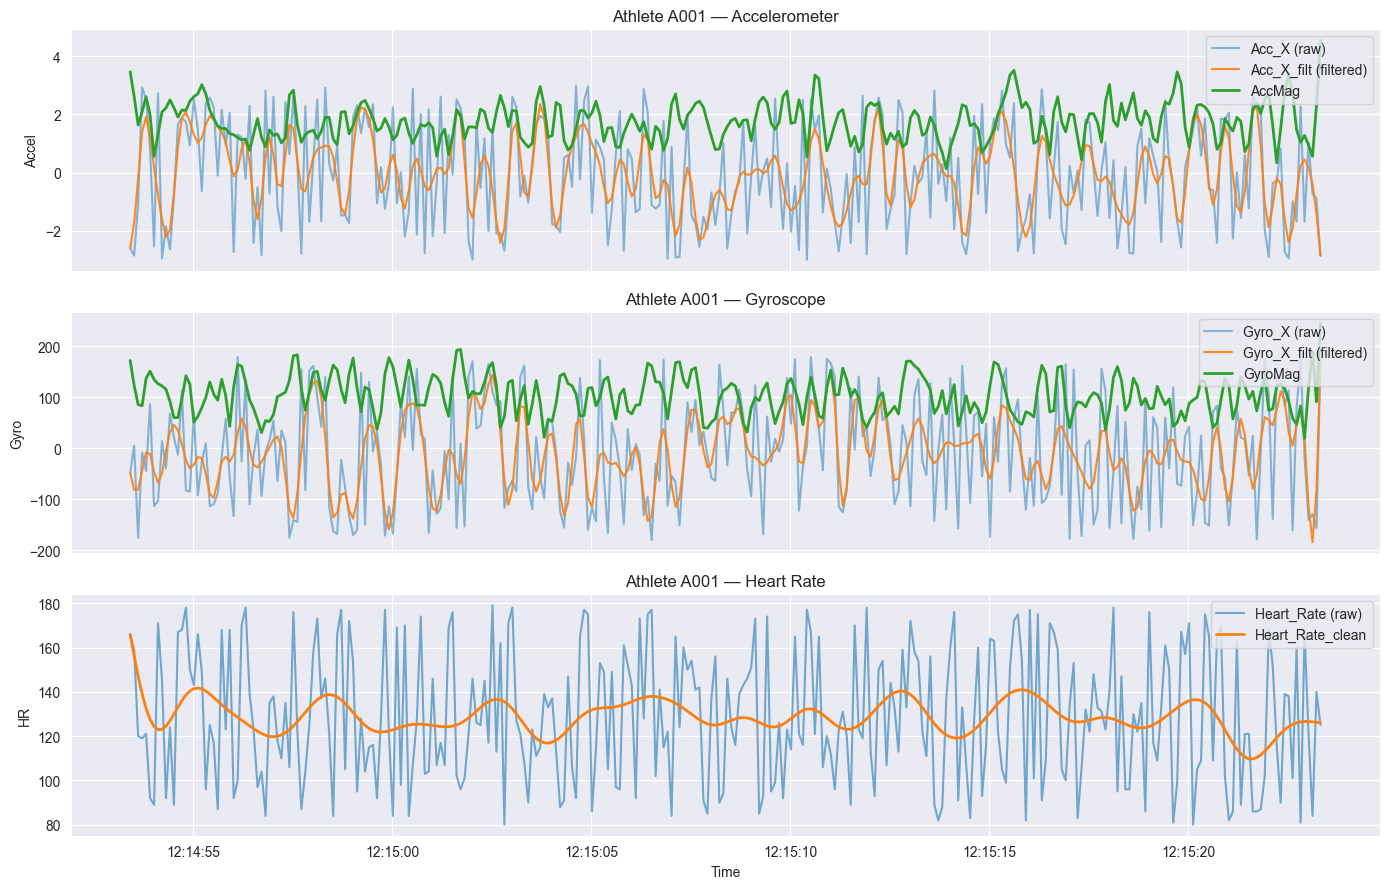

In [12]:
# Quick Plot: one athlete — HR + Accel + Gyro (raw vs filtered vs magnitude where available)

pid0 = df_pre[id_col].iloc[0]
g = df_pre[df_pre[id_col] == pid0].sort_values(ts_col).reset_index(drop=True)

# Try to find one representative accel/gyro axis (raw + filt)
raw_acc = next((c for c in acc_cols if c in g.columns), None)
filt_acc = raw_acc + "_filt" if raw_acc and (raw_acc + "_filt") in g.columns else None

raw_gyro = next((c for c in gyro_cols if c in g.columns), None)
filt_gyro = raw_gyro + "_filt" if raw_gyro and (raw_gyro + "_filt") in g.columns else None

# Heart rate columns
raw_hr = hr_col if (hr_col and hr_col in g.columns) else None
clean_hr = "Heart_Rate_clean" if "Heart_Rate_clean" in g.columns else None

fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

# --- Accel ---
ax = axes[0]
if raw_acc:
    ax.plot(g[ts_col], g[raw_acc], label=f"{raw_acc} (raw)", alpha=0.5)
if filt_acc:
    ax.plot(g[ts_col], g[filt_acc], label=f"{filt_acc} (filtered)", alpha=0.9)
if "AccMag" in g.columns:
    ax.plot(g[ts_col], g["AccMag"], label="AccMag", linewidth=2)
ax.set_title(f"Athlete {pid0} — Accelerometer")
ax.set_ylabel("Accel")
ax.legend(loc="upper right")

# --- Gyro ---
ax = axes[1]
if raw_gyro:
    ax.plot(g[ts_col], g[raw_gyro], label=f"{raw_gyro} (raw)", alpha=0.5)
if filt_gyro:
    ax.plot(g[ts_col], g[filt_gyro], label=f"{filt_gyro} (filtered)", alpha=0.9)
if "GyroMag" in g.columns:
    ax.plot(g[ts_col], g["GyroMag"], label="GyroMag", linewidth=2)
ax.set_title(f"Athlete {pid0} — Gyroscope")
ax.set_ylabel("Gyro")
ax.legend(loc="upper right")

# --- Heart Rate ---
ax = axes[2]
if raw_hr:
    ax.plot(g[ts_col], g[raw_hr], label=f"{raw_hr} (raw)", alpha=0.6)
if clean_hr:
    ax.plot(g[ts_col], g[clean_hr], label="Heart_Rate_clean", linewidth=2)
ax.set_title(f"Athlete {pid0} — Heart Rate")
ax.set_ylabel("HR")
ax.set_xlabel("Time")
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()


This notebook preprocesses a multi-athlete biosensor dataset to prepare it for windowing and machine-learning analysis. Preprocessing is performed per athlete, treating (Athlete_ID, Timestamp) as the true data key to prevent mixing sensor streams from different individuals and to enable subject-level evaluation such as LOSO. Timestamps are parsed and sorted, duplicate timestamps within an athlete are safely aggregated, and missing sensor values are repaired using forward/backward filling and interpolation.

To reduce sensor noise while preserving human movement dynamics, we apply low-pass Butterworth filtering to accelerometer and gyroscope signals (20 Hz cutoff) and mild smoothing to heart-rate signals (5 Hz cutoff). We then compute acceleration and gyroscope magnitudes from the filtered axes to obtain orientation-independent measures of movement intensity. Throughout the pipeline, sanity checks verify athlete counts, recording durations, sampling rates, and label distributions to ensure no data are lost. This preprocessing step produces clean, structured signals that are suitable for segmentation, feature extraction, and reliable downstream modeling.

In [13]:
OUT_PATH = Path("../data/biosensor_preprocessed_all.csv")
df_pre.to_csv(OUT_PATH, index=False)
print("Saved:", OUT_PATH)

Saved: ..\data\biosensor_preprocessed_all.csv
